# Integrity check for state estimation solutions

- Implementing a new pipeline to determine if we can create more meaningful integrity bounds for pose estimations
- Starting with a weighted least squares based on micropatch analysis

### Big picture 
- Generate projection comparisons between pose estimates and reference map
    - New SSD version formulation
- Formulate jacobian matrix to measure change over small perturbations
- Formulate measurement covariance matrix R
- Use R to generate position estimate covariance P

# CHECKLIST 
1) [x] Import turf imagery and SfM estimates (and ground truth)
2) [x] Implement pose estimations and 'converged solution' for individual patches
3) [x] Divide each patch into micro patches
4) [ ] Calculate error vector for each micropatch
5) [ ] Generate mean and covariance data for a set of micropatches
6) [ ] Combine into 2Mx2M R matrix for M patches
7) [ ] Weighted LSquares
8) [ ] Implement on airport data?

### Micropatch division checklist
- [x] Grab patch from ground image
- [x] Project patch onto satellite imagee
- [x] Determine cartesian satellite grid from middle point and corner boundaries

This way, we are keeping the same N number of points for each SSD comparison
However, the number of SSDs may change (?) - **Keep this in mind**

Unknowns

$$
\mathbf{x} = [X, Y, Z, \phi, \theta, \psi]^T
$$


Generating SSD values for n micropatches

$$
\mathrm{SSD}_i(\Delta x, \Delta y)
=
\sum_{(p,q)}\sum_{ \in A_g}
\Big[
    I_i(p + \Delta x,\; q + \Delta y)
    - I_s(p, q)
\Big]^2
$$

The correction vector over each micropatch i represented by 

$$
\mathbf{e}_i
=
\begin{bmatrix}
e_x \\
e_y
\end{bmatrix}
=
\arg\min_{\Delta x,\;\Delta y}
\mathrm{SSD}_i(\Delta x,\Delta y)
$$

Across n micropatches 

MEAN

$$
\boldsymbol{\mu}
=
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
=
\frac{1}{n}\sum_{i=1}^{n}
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
$$


VARIANCE 
$$
R_p
=
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} \\
\sigma_{xy} & \sigma_y^2
\end{bmatrix}
=
\frac{1}{n-1}
\sum_{i=1}^{n}
\Bigg(
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
-
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
\Bigg)
\Bigg(
\begin{bmatrix}
e_{x,i} \\
e_{y,i}
\end{bmatrix}
-
\begin{bmatrix}
\bar e_x \\
\bar e_y
\end{bmatrix}
\Bigg)^{T}
$$


Across m projections (images poses)

$$
R_m
=
\begin{bmatrix}
R_1 & 0 & \cdots & 0 \\
0 & R_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & R_m
\end{bmatrix},
\quad
R_i =
\begin{bmatrix}
\sigma_{x,i}^2 & \sigma_{xy,i} \\
\sigma_{xy,i} & \sigma_{y,i}^2
\end{bmatrix}
$$

$$
\mathrm{SSD}_n(\Delta x, \Delta y)
=
\sum_{p}\sum_{q \in A_g}
\Big[m \Big]^2
$$


$$
\mathbf{e}_i
=
\begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

In [1]:
import numpy as np 
import cv2
from groundNAV_agent import *


# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

/home/daniel-choate/miniconda3/envs/py39/lib/python3.9/site-packages/dash/dash.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, parse_version


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# SfM files 
images_colm = '../TurfData/SfM_soln/images.txt'
cameras_colm = '../TurfData/SfM_soln/cameras.txt'
pts3d_colm = '../TurfData/SfM_soln/points3D_f.txt'

# Local images - folder
# im_local = '../TurfData/local_imgs_10' # With 10 local images 
im_local = '../TurfData/local_imgs_5' # With 5 local images

# Satellite reference image
sat_ref = '../TurfData/TurfSat.jpg'

In [3]:
# Create class 
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, im_local, sat_ref)

### Implement pose estimations and ground truth solutions

In [4]:
# SET REFERENCE FRAME
# Set reference frame - transform to ground-parallel coordinate frame 
tform_ref_frame = gnav.set_ref_frame(gnav.pts_gnd_idx)
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("\nReference frame transformation\n", tform_ref_frame_pts)

# Transfer all points to new coordinate system
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(gnav.scene_pts, gnav.origin_w, tform_ref_frame_pts)


Reference frame transformation
 [[-1.55069060e-03  9.81197008e-01  1.93002661e-01 -1.21025836e-01]
 [-1.42845166e-01 -1.91240997e-01  9.71093270e-01  1.86102525e+00]
 [ 9.89743833e-01 -2.60636319e-02  1.40455805e-01  7.28134156e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


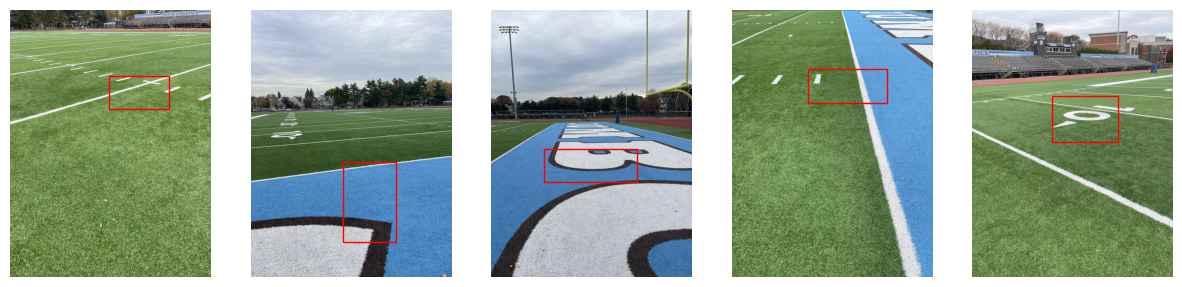

In [5]:
# Import mosaic parameters - arbitrarily obtained, can be modified
mosaic_params = np.load('../TurfData/GP_sections/mosaic_params.npy')
# Grab specified image points from local images 
gnav.grab_image_pts_tot(mosaic_params)

plt.figure(figsize=(15,8))
gnav.plot_gnd_pts()

In [6]:
# Generate projection of image sections 
for i in range(len(gnav.images_dict)):
    # STEP 1: Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # STEP 2: Transformation matrix moves from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # STEP 3: Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # STEP 4: Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # STEP 5: Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4


In [7]:
# Initial guess parameters 
# 5 image solution
scale, yaw, x_g, y_g = 80, np.deg2rad(140), -52, 20
# BEST after CONVERGENCE
scale = 80.14819958
yaw = 2.44777939
x_g = -55.46495001
y_g = 21.62910054

tform_guess = gnav.tform_create(x_g,y_g,0,0,0,yaw)
gnav.best_guess_tform = tform_guess
gnav.best_guess_scale = scale

# Implement
gnav.implement_guess(gnav.best_guess_tform, gnav.best_guess_scale)

In [8]:
# Create visualization
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Image mosaic with reference map (initial guess)")

gnav.mosaic_w_ref_visualization(vis)

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 80
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 80
pci id for fd 80: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


### Divide each patch into micro-patches

- [x] Grab patch from ground image
- [x] Project patch onto satellite image (trapezoid)
- [x] Find bounds of trapezoid
- [x] Divide bounding box into uniform squares
- [x] Check which squares are fully within the trapezoid

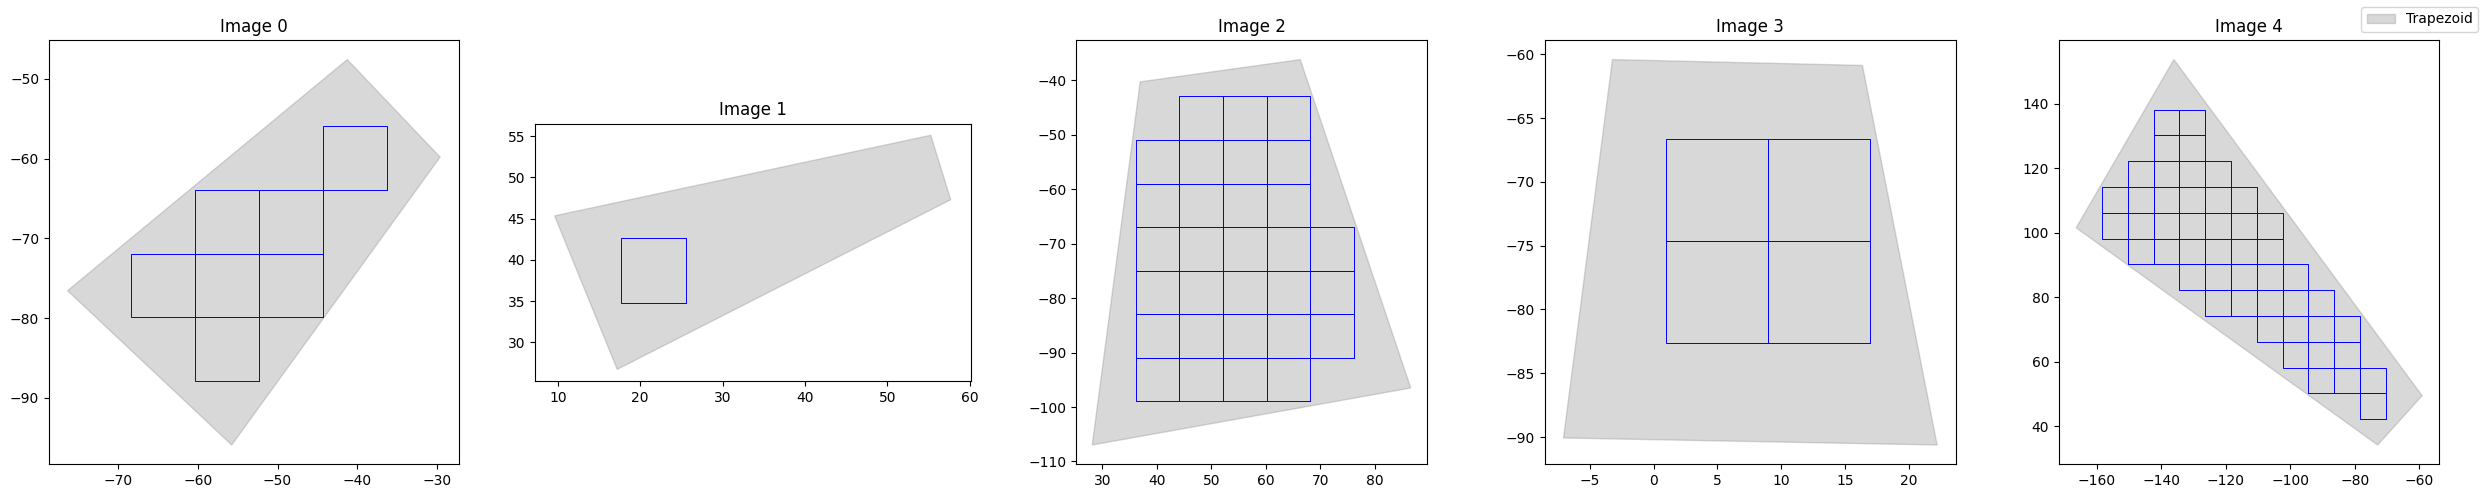

In [22]:
n = 8
micro_ps = gnav.micropatch_division(n)
gnav.plot_traps_w_microps()

In [23]:
print([len(micro_ps[i]) for i in range(5)])

[7, 1, 30, 4, 48]


In [ ]:
# Check that the points are at least proper

# PLOTTING THE NEW SCENE MOSAIC

# Use open3d to create point cloud visualization 
# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mosaic scene with satellite reference")

# Create axes @ origin
axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
vis.add_geometry(axis_origin)

# Add image patches
# for i in range(len(gnav.images_dict)):
# for i in range(2):
#     cloud = o3d.geometry.PointCloud()
#     cloud.points = o3d.utility.Vector3dVector(gnav.im_pts_best_guess[i]['pts'])
#     cloud.colors = o3d.utility.Vector3dVector(gnav.im_mosaic[i]['color_g'])
#     vis.add_geometry(cloud)


# Create point cloud for image points
for i in range(len(gnav.images_dict)):
    for j in range(len(micro_ps[i])):
        # print(j)
        cloud_micro = o3d.geometry.PointCloud()
        cloud_micro.points = o3d.utility.Vector3dVector(micro_ps[i][j]['pts'])
        cloud_micro.paint_uniform_color([.75, 0.001*j, 0.002*j])
        # cloud_micro.colors = o3d.utility.Vector3dVector(micro_ps[i][j]['color_g'])
        vis.add_geometry(cloud_micro)

# Run and destroy visualization 
vis.run()
vis.destroy_window()

Process:
- [ ] Gather SSDs from each individual patch
- [ ] Calculate minimum for each patch
- [ ] Generate vector to minimum location
- [ ] Plot vectors across each micropatch

In [12]:
# # Loop through images and patches
# n = 5
# for i in range(len(gnav.images_dict)): # Formatting fix
#     gnav.ssds_curr_micro[i] = {}


# for imnum in range(len(gnav.images_dict)):
#     for b, __ in bins_2d.items():
#         if b[0] != imnum:
#             continue
#         ssds = gnav.ssd_nxn_micro(n, imnum, b)
#         break
#     break